In [78]:
import re
import os
import pathlib
import json

import plotnine
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")


In [2]:
experiment = "02_http_constant_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()
results_dir


PosixPath('/Users/richardbieringa/Projects/mesh-bench/results/02_http_constant_throughput')

In [181]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""



# Regex to extra# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

# Traverse all files in the results directory and construct dataframes form them
dfs = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Extract metadata from the result
        matches = re.match(name_re, file)

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        with open(p) as f:
            data = json.loads(f.read())
            
            # Transform the flattened json into a dataframe
            df = pd.json_normalize(data)
            df["mesh"] = matches[2]
            df["payload"] = matches[4]
            df["repetition"] = matches[5]

            dfs.append(df)

df = pd.concat(dfs)
df

Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 100


,RunType,Labels,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,NumThreads,Version,Exactly,...,HeaderSizes.Min,HeaderSizes.Max,HeaderSizes.Sum,HeaderSizes.Avg,HeaderSizes.StdDev,HeaderSizes.Data,HeaderSizes.Percentiles,mesh,payload,repetition
0,HTTP,,2022-06-13T11:08:49.178555638Z,500,5m0s,499.894997,300031008566,32,1.28.0,0,...,75,75,11248800,75.00000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4
0,HTTP,,2022-06-13T11:33:50.143546834Z,1500,5m0s,1499.892052,300010923723,32,1.28.0,0,...,75,75,33748800,75.00000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4
0,HTTP,,2022-06-13T19:45:20.74857595Z,1500,5m0s,1499.354378,300011129285,32,1.28.0,0,...,249,250,112005999,249.00016,0.012651,"[{'Start': 249, 'End': 250, 'Percent': 100, 'C...",None,istio,0,5
0,HTTP,,2022-06-13T15:52:37.308019858Z,1500,5m0s,1499.726680,300010665856,32,1.28.0,0,...,115,115,51742410,115.00000,0.000000,"[{'Start': 115, 'End': 115, 'Percent': 100, 'C...",None,linkerd,0,4
0,HTTP,,2022-06-14T10:09:06.327442509Z,2500,5m0s,2499.003115,300006828879,32,1.28.0,0,...,115,115,86217570,115.00000,0.000000,"[{'Start': 115, 'End': 115, 'Percent': 100, 'C...",None,cilium,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HTTP,,2022-06-14T00:26:29.70839696Z,2500,5m0s,512.101923,300014495357,32,1.28.0,0,...,75,75,11522850,75.00000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,traefik,0,2
0,HTTP,,2022-06-14T09:39:04.804797359Z,1500,5m0s,1499.214322,300010474455,32,1.28.0,0,...,115,115,51724700,115.00000,0.000000,"[{'Start': 115, 'End': 115, 'Percent': 100, 'C...",None,cilium,0,3
0,HTTP,,2022-06-13T15:22:36.094979113Z,500,5m0s,499.895677,300030600305,32,1.28.0,0,...,115,115,17248160,115.00000,0.000000,"[{'Start': 115, 'End': 115, 'Percent': 100, 'C...",None,linkerd,0,3
0,HTTP,,2022-06-13T15:02:34.977912766Z,100,5m0s,99.896318,300151201418,32,1.28.0,0,...,115,115,3448160,115.00000,0.000000,"[{'Start': 115, 'End': 115, 'Percent': 100, 'C...",None,linkerd,0,4


In [204]:
key = "DurationHistogram.Data"

# Add Seperate columns for the histogram data points
df['start'] = df[key].apply(lambda x: [e['Start'] for e in x])
df['end'] = df[key].apply(lambda x: [e['End'] for e in x])
df['percent'] = df[key].apply(lambda x: [e['Percent'] for e in x])
df['count'] = df[key].apply(lambda x: [e['Count'] for e in x])



In [248]:
df1 = df[df["mesh"] == "baseline"]
df1 = df1.drop_duplicates(subset=["RequestedQPS"])
df["RequestedQPS"] = pd.to_numeric(df["RequestedQPS"])
df1 = df1.sort_values(by=["RequestedQPS"])
kdf1

,RunType,Labels,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,NumThreads,Version,Exactly,...,HeaderSizes.StdDev,HeaderSizes.Data,HeaderSizes.Percentiles,mesh,payload,repetition,start,end,percent,count
0,HTTP,,2022-06-13T10:33:47.283722518Z,100,5m0s,99.896412,300150921069,32,1.28.0,0,...,0.0,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,2,"[0.000129411, 0.00014000000000000001, 0.00016,...","[0.00014000000000000001, 0.00016, 0.00018, 0.0...","[0.013340448239060833, 0.2001067235859125, 1.4...","[4, 56, 386, 1398, 9119, 13375, 3901, 973, 359..."
0,HTTP,,2022-06-13T11:08:49.178555638Z,500,5m0s,499.894997,300031008566,32,1.28.0,0,...,0.0,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4,"[8.9733e-05, 9e-05, 0.0001, 0.00011, 0.0001200...","[9e-05, 0.0001, 0.00011, 0.0001200000000000000...","[0.0006667377853637721, 0.05067207168764668, 0...","[1, 75, 484, 2012, 21287, 51822, 42747, 17860,..."
0,HTTP,,2022-06-13T11:33:50.143546834Z,1500,5m0s,1499.892052,300010923723,32,1.28.0,0,...,0.0,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4,"[5.8309e-05, 6.000000000000001e-05, 7.00000000...","[6.000000000000001e-05, 7.000000000000001e-05,...","[0.0002222301237377329, 0.0031112217323282605,...","[1, 13, 65, 1993, 10700, 27816, 46500, 124095,..."
0,HTTP,,2022-06-13T11:58:51.05332102Z,2500,5m0s,2499.057459,300006707398,32,1.28.0,0,...,0.0,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4,"[5.0273e-05, 6.000000000000001e-05, 7.00000000...","[6.000000000000001e-05, 7.000000000000001e-05,...","[0.005601986837998544, 0.08016176403897916, 0....","[42, 559, 1681, 5587, 18028, 31986, 37260, 672..."


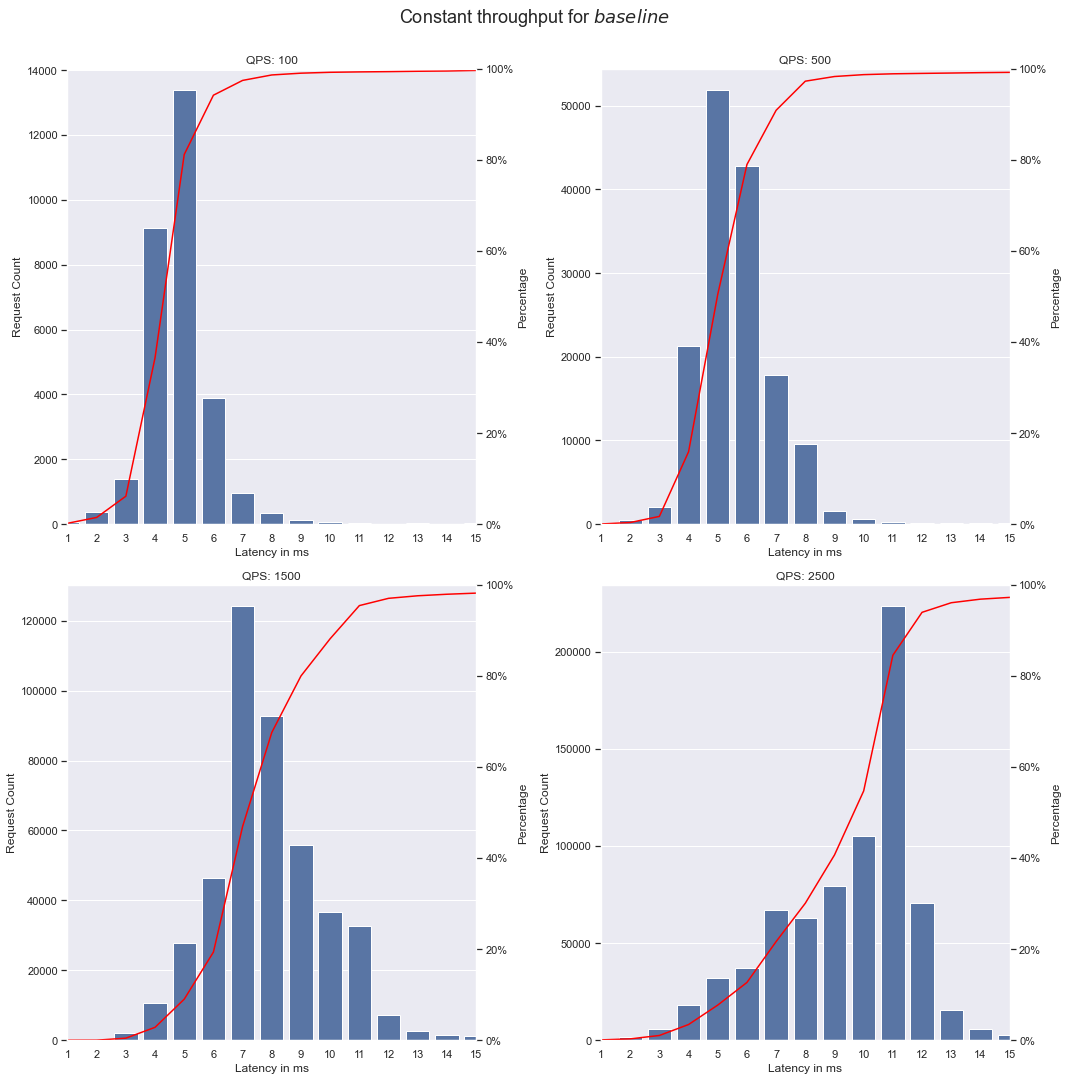

In [253]:


# Create grid of 1x1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
fig.suptitle("Constant throughput for $baseline$", fontsize=18, y=1)

for i, ax in enumerate(fig.axes):
    row = df1.iloc[i]

    # Get the histogram data
    data = row["DurationHistogram.Data"]

    # Extract the information we require
    bins = [x["Start"] for x in data]
    bins.append(data[-1]["End"])
    perc = [x["Percent"] for x in data]
    count = [x["Count"] for x in data]

    qps = row["RequestedQPS"]


    # Bar plot showing the binned variables
    sns.barplot(x=bins[:-1], y=count, color="b", ax=ax)

    # Labels
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency in ms")
    ax.set_title(f"QPS: {qps}")

    # Logarithmic x axis from 1->50
    # ax.set_xscale("log")
    ax.set_xlim(1, 15)

    # ax.set_xticks(range(1, 11))
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    # instantiate a second axes that shares the same x-axis
    ax2 = ax.twinx()
    ax2.set_ylabel("Percentage")
    ax2.set_ylim(0, 100)
    ax2.plot(perc, color="red")
    ax2.set_alpha(0.5)
    ax2.grid(False)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter())


    fig.tight_layout()

plt.show()

In [147]:
bins = [x["Start"] for x in data]
bins.append(data[-1]["End"])
bins = np.array(bins)
bins = bins * 1000


counts = np.array([x["Count"] for x in data])
bins

perc = [x["Percent"] for x in data]


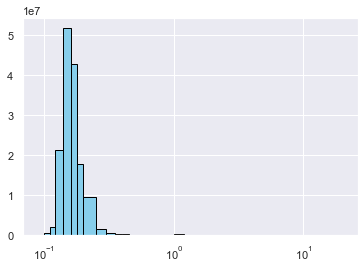

In [41]:

fix,ax = plt.subplots()
ax.bar(x=bins[:-1], height=counts, width=np.diff(bins), align='edge', fc='skyblue', ec='black')
ax.set_xscale("log")

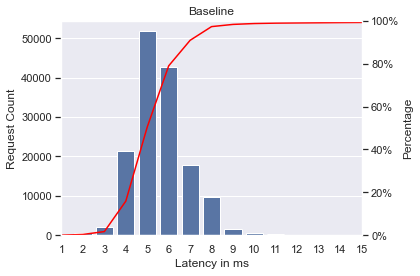

In [163]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker



# Create grid of 1x1
fig,ax = plt.subplots()

# Bar plot showing the binned variables
ax = sns.barplot(x=bins[:-1], y=counts, color="b")

# Labels
ax.set_ylabel("Request Count")
ax.set_xlabel("Latency in ms")
ax.set_title("Baseline")

# Logarithmic x axis from 1->50
# ax.set_xscale("log")
ax.set_xlim(1, 15)

# ax.set_xticks(range(1, 11))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()
ax2.set_ylabel("Percentage")
ax2.set_ylim(0, 100)
ax2.plot(perc, color="red")
ax2.set_alpha(0.5)
ax2.grid(False)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())


fig.tight_layout()

plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

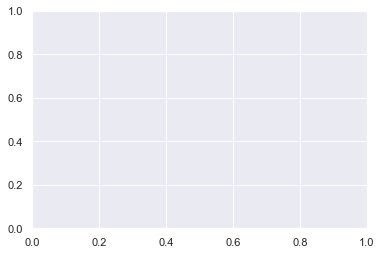

In [144]:
# Create grid of 1x1
fix,ax = plt.subplots()

# Bar plot showing the binned variables
ax = sns.kdeplot(data=data, x=bins[:-1], y=counts)